In [2]:
import numpy as np
from scipy.optimize import minimize
import csv
import random
import matplotlib.pyplot as plt
import copy
import math

In [3]:
parkingLotSize = 173
# chargingProbability = 0.25 #REMOVE
installCost = 5000
rebatePercent = 0.7
hydroPrice = 1.25 #Dollars per kWhour - FILLER NOT REAL VALUE
markup = 0.25 #Dollars per kWhour
weeks = 522 #10 years
batteryEnergy = 57 #kWh, small SUV, BEV200, 2015
batteryPower = 157 #kW, small SUV, BEV200, 2015

In [4]:
# Open the CSV file
csv_file = open('time_demand.csv', 'r')
csv_file2 = open('vehicle_registration_2022.csv', 'r')

# Create a csv.reader object
csv_reader = csv.reader(csv_file)
csv_reader2 = csv.reader(csv_file2)

# Initialize an empty array to store the CSV data
data_array = []
data_array2 = []

# Read and store data row by row
for row in csv_reader:
    data_array.append(row)
for row in csv_reader2:
    data_array2.append(row)

# Close the CSV file
csv_file.close()
csv_file2.close()

demandHourly = [item for sublist in [row[1:] for row in data_array[1:-1]] for item in sublist]
vehicleRegistration2022 = data_array2

In [5]:
#Need a script that calculates percent of vehicles in area that are EVs based on vehicle registration data
#Defines variable percentEV

# Specify the column index you want to analyze
column_index = 3  # 3 corresponds to EV included
target_text = "Yes"
count_matches = 0

# Iterate through the rows and check for matches
for row in vehicleRegistration2022[1:]:  # Skip the header row
    if row[column_index] == target_text:
        count_matches += 1

# Calculate the percentage
total_rows = len(vehicleRegistration2022) - 1  # Subtract 1 to exclude the header row
percentEV = count_matches / total_rows
percentEV

0.03045657988467897

In [6]:
def chargingDemand(demandHourly,percentEV,chargerCount,parkingLotSize):
    #Takes inputs: array demandHourly which is 13 (hours per day) by 7 (days per week), float percentEV, float chargingProbability
    #Returns total number of charging instances per week weeklyChargeCount
    
    weeklyChargeCount = 0
    randomCarArray = []
    chargers = [[False,"",""]]*(chargerCount)
    chargersFilled = [chargers]
    falses = []
    chargersOccupied = 0
    for i in demandHourly:
        
        parkingSpots = [False,"",""]*(173 - chargerCount)
        chargers = sorted(chargers, key=lambda x: not x[0])
        
        #Cars leaving/staying at chargers:
        for k, car in enumerate(chargers):
            if car[0] and car[2] >= 100:
                chargers[k] = [False,"",""]
                chargersOccupied -= 1
            #ASSUMING CAR CHARGES TO 100%
            elif car[0] and car[2] < 100:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                chargers[k][2] += 20
                
        #Sort chargers so filled comes first
        chargers = sorted(chargers, key=lambda x: not x[0])
                
        for j, car in enumerate(parkingSpots):
            randomCar = generateCar(float(i),percentEV)
            randomCarArray.append(randomCar)
            #if random car is EV that wants to charge:
            if randomCar[1] and randomCar[2] < 40 and chargersOccupied < chargerCount:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                randomCar[2] += 20
                #car parks in charger spot
                chargers = sorted(chargers, key=lambda x: not x[0])
                chargers[chargersOccupied] = randomCar
                chargersOccupied += 1
            else:
                #car parks in regular spot
                parkingSpots[j] = randomCar
                
        chargersFilled.append(copy.deepcopy(chargers))
        
        weeklyChargeCount += chargersOccupied
            
    return(weeklyChargeCount,chargersFilled)


In [7]:
def generateCar(demand,percentEV):
    #generates a Car: array of length 3 [does the car exist?,is the car an EV?,SOC]
    #to do: add additional car properties
    #if the spot is empty (random number is above % chance that spot is filled)
    car = [False,"",""]
    if random.randint(1, 100) > (demand*100):
        return car
    #if car is EV
    elif random.randint(1, 100) < (percentEV*100):
        car[0] = True
        car[1] = True
        car[2] = random.randint(20, 80)
    else:
        car[0] = True
        car[1] = False
    
    return car

# counttest = 100
# test = []
# while counttest > 0:
#     test.append(generateCar(0.5,0.1))
#     counttest -= 1
# test

In [8]:
chargingDemand(demandHourly,percentEV,3,parkingLotSize)

(260,
 [[[False, '', ''], [False, '', ''], [False, '', '']],
  [[True, True, 40], [True, True, 56], [True, True, 42]],
  [[True, True, 60], [True, True, 76], [True, True, 62]],
  [[True, True, 80], [True, True, 96], [True, True, 82]],
  [[True, True, 100], [True, True, 116], [True, True, 102]],
  [[False, '', ''], [False, '', ''], [False, '', '']],
  [[False, '', ''], [False, '', ''], [False, '', '']],
  [[True, True, 41], [True, True, 51], [False, '', '']],
  [[True, True, 61], [True, True, 71], [True, True, 54]],
  [[True, True, 81], [True, True, 91], [True, True, 74]],
  [[True, True, 101], [True, True, 111], [True, True, 94]],
  [[True, True, 114], [True, True, 53], [True, True, 53]],
  [[True, True, 73], [True, True, 73], [False, '', '']],
  [[True, True, 93], [True, True, 93], [True, True, 48]],
  [[True, True, 113], [True, True, 113], [True, True, 68]],
  [[True, True, 88], [True, True, 53], [True, True, 46]],
  [[True, True, 108], [True, True, 73], [True, True, 66]],
  [[True, 

In [ ]:
def powerToHour(hydroPrice,markup,batteryPower):
    #Calculates the price per hour based on price per kWh
    priceEnergy = hydroPrice + markup #$/kWh
    priceHour = priceEnergy*batteryPower #$/kWh * kW = $/h
    return(priceHour)
hourlyPrice = powerToHour(hydroPrice,markup,batteryPower)

In [156]:
def profit(installCost,rebatePercent,weeks,demandHourly,percentEV,chargers,parkingLotSize,hourlyPrice):
    #Takes inputs: float installCost in CAD, float rebatePercent, chargeCharge in CAD/hour (change this eventually to CAD/kWh and weeklyChargeCount to kwH/week)
    #plus params for ChargingDemand
    revenue = 0
    revenueWeekly = []
    costs = installCost*(1-rebatePercent)*chargers
    #This needs to be adjusted for inflation later
    while weeks > 0:
        weekRevenue = chargingDemand(demandHourly,percentEV,chargers,parkingLotSize)[0] * hourlyPrice
        revenue += weekRevenue
        revenueWeekly.append(revenue)
        weeks -= 1
    return(revenue-costs,revenueWeekly)
    #Returns total profit/loss in CAD

In [ ]:
def EVDemandIncrease(markup,chargers):
    coeffs = {
        1:[0.1997,-0.032]
        ,2:[0.1997,-0.032]
        ,3:[0.1997,-0.032]
        ,4:[0.2193,-0.031]
        ,5:[0.2193,-0.031]
        ,6:[0.2193,-0.031]
        ,7:[0.227,-0.028]
        ,8:[0.227,-0.028]
        ,9:[0.227,-0.028]
        ,10:[0.2325,-0.027]
        ,11:[0.2325,-0.027]
        ,12:[0.236,-0.026]
        ,13:[0.236,-0.026]
        ,14:[0.2405,-0.025]
        ,15:[0.2405,-0.025]
        ,16:[0.2405,-0.025]
    }
    return(coeffs[chargers][0]*math.exp(coeffs[chargers][1]*markup))
    

In [ ]:
#Lifecycle analysis later

In [ ]:
#Battery modelling later (this might go in the script up top actually)

In [141]:
def chargerSizing(installCost,rebatePercent,chargeCharge,weeks,demandHourly,percentEV,chargingProbability):
    #This is an optimization function that finds the optimal number of chargers to maximize profit
    defaultChargers = 1
    
    bnds = [(1,91)]
    result = minimize(lambda x: -profit(installCost,rebatePercent,chargeCharge, weeks, demandHourly,percentEV,chargingProbability,x,parkingLotSize)[0], defaultChargers, bounds=bnds)
    chargers = result.x[0]
    netprofit = -result.fun
    return(chargers)

In [144]:
chargerSizing(installCost,rebatePercent,chargeCharge,weeks,demandHourly,percentEV,chargingProbability)

1.0000035120035085

In [157]:
revenueWeekly = profit(installCost,rebatePercent,chargeCharge, weeks, demandHourly,percentEV,chargingProbability,1,parkingLotSize)

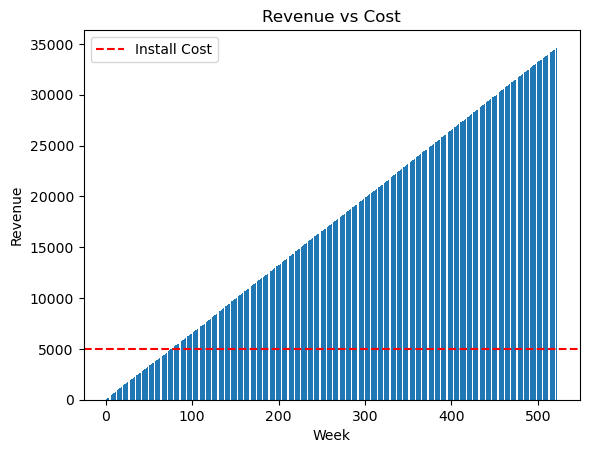

In [160]:
# Create the bar graph with position-based labels
plt.bar(range(1, len(revenueWeekly[1]) + 1), revenueWeekly[1])

# Add a horizontal line at y=installCost
plt.axhline(y=installCost, color='red', linestyle='--', label='Install Cost')

# Set the title and labels for the axes
plt.title('Revenue vs Cost')
plt.xlabel('Week')
plt.ylabel('Revenue')

# Display the legend
plt.legend()

# Show the plot
plt.show()